<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

1.1. Загрузим библиотеки и данные фрейма

In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns
import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.metrics import make_scorer, mean_squared_error 
from statsmodels.graphics.tsaplots import plot_acf

import warnings


In [5]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

In [6]:
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


1.2.Проанализируем имеющиеся данные

<AxesSubplot:xlabel='datetime'>

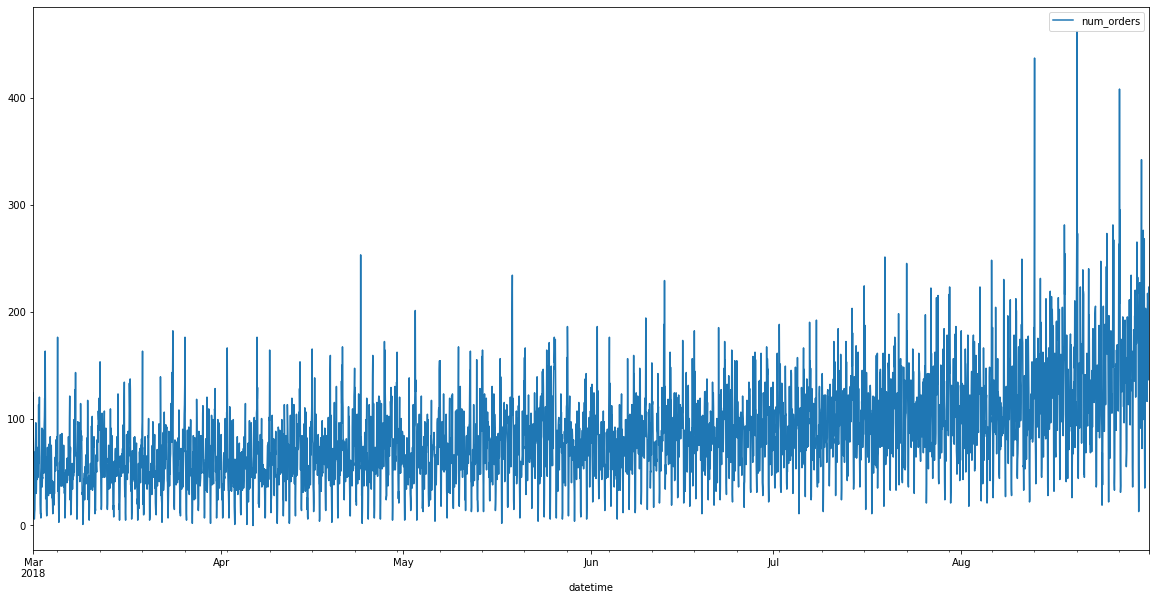

In [8]:
data = data.resample('1H').sum()
figsize = (20,10)
data.plot(figsize=figsize)

Исходный датасет состоит из следующих столбцов: 
- datetime — дата и время заказа такси 
- num_orders — количество заказов такси (целевой признак) 

Пропуски в данных отсутствуют.

## Анализ

In [9]:
print('Выгрузка начинается с:',data.index.min())
print('Выгрузка заканчивается:',data.index.max())
print('Всего дней:',data.index.max() - data.index.min())

Выгрузка начинается с: 2018-03-01 00:00:00
Выгрузка заканчивается: 2018-08-31 23:00:00
Всего дней: 183 days 23:00:00


In [10]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


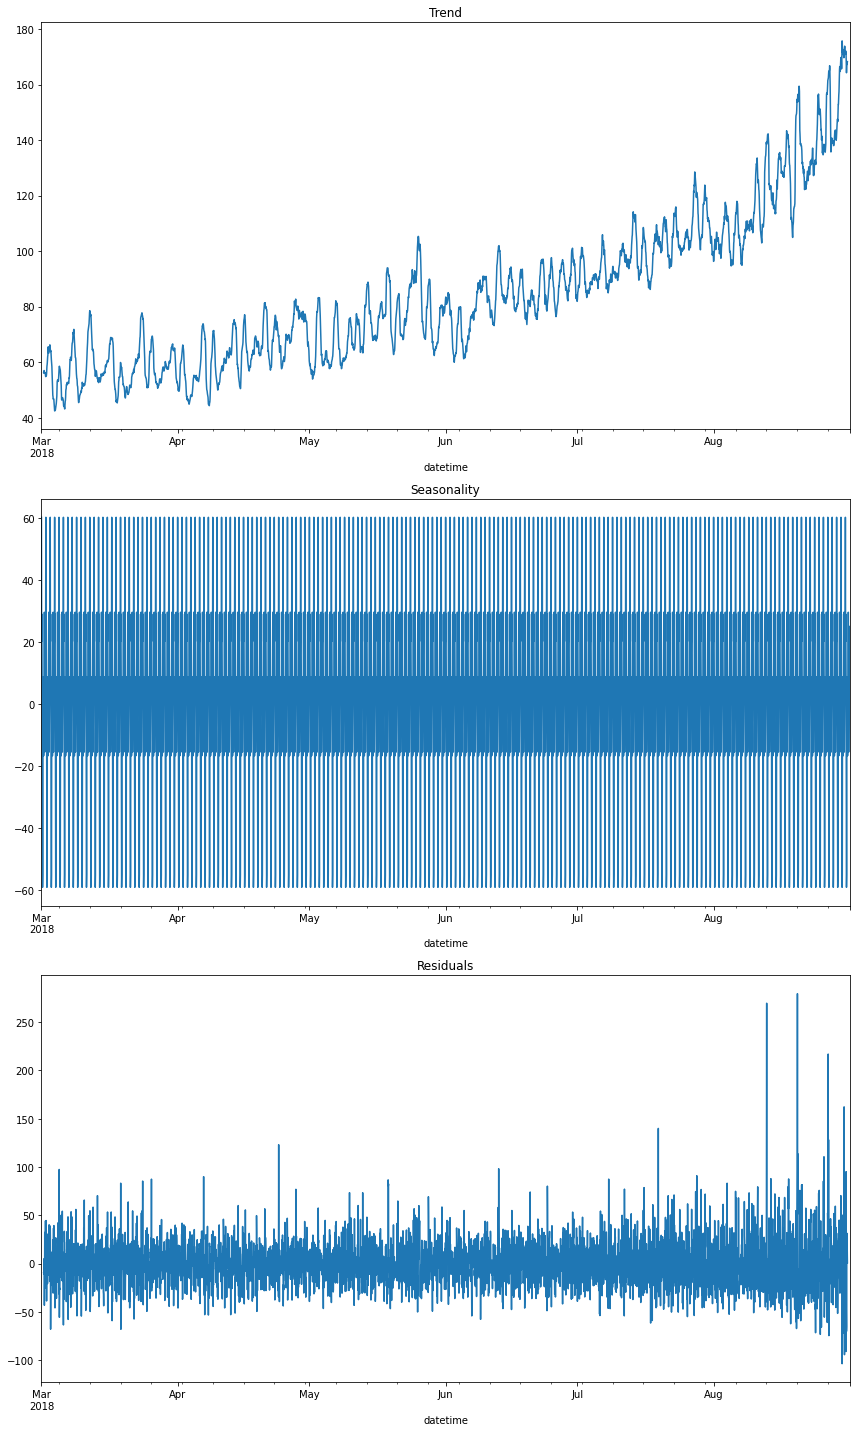

In [11]:
decomposed_data = seasonal_decompose(data)

plt.figure(figsize=(12, 20))

# Plot Trend
plt.subplot(3, 1, 1)
decomposed_data.trend.plot()
plt.title('Trend')

# Plot Seasonality
plt.subplot(3, 1, 2)
decomposed_data.seasonal.plot()
plt.title('Seasonality')

# Plot Residuals
plt.subplot(3, 1, 3)
decomposed_data.resid.plot()
plt.title('Residuals')

plt.tight_layout()
plt.show()

Рассмотрим более детально последние 2 полные недели мая

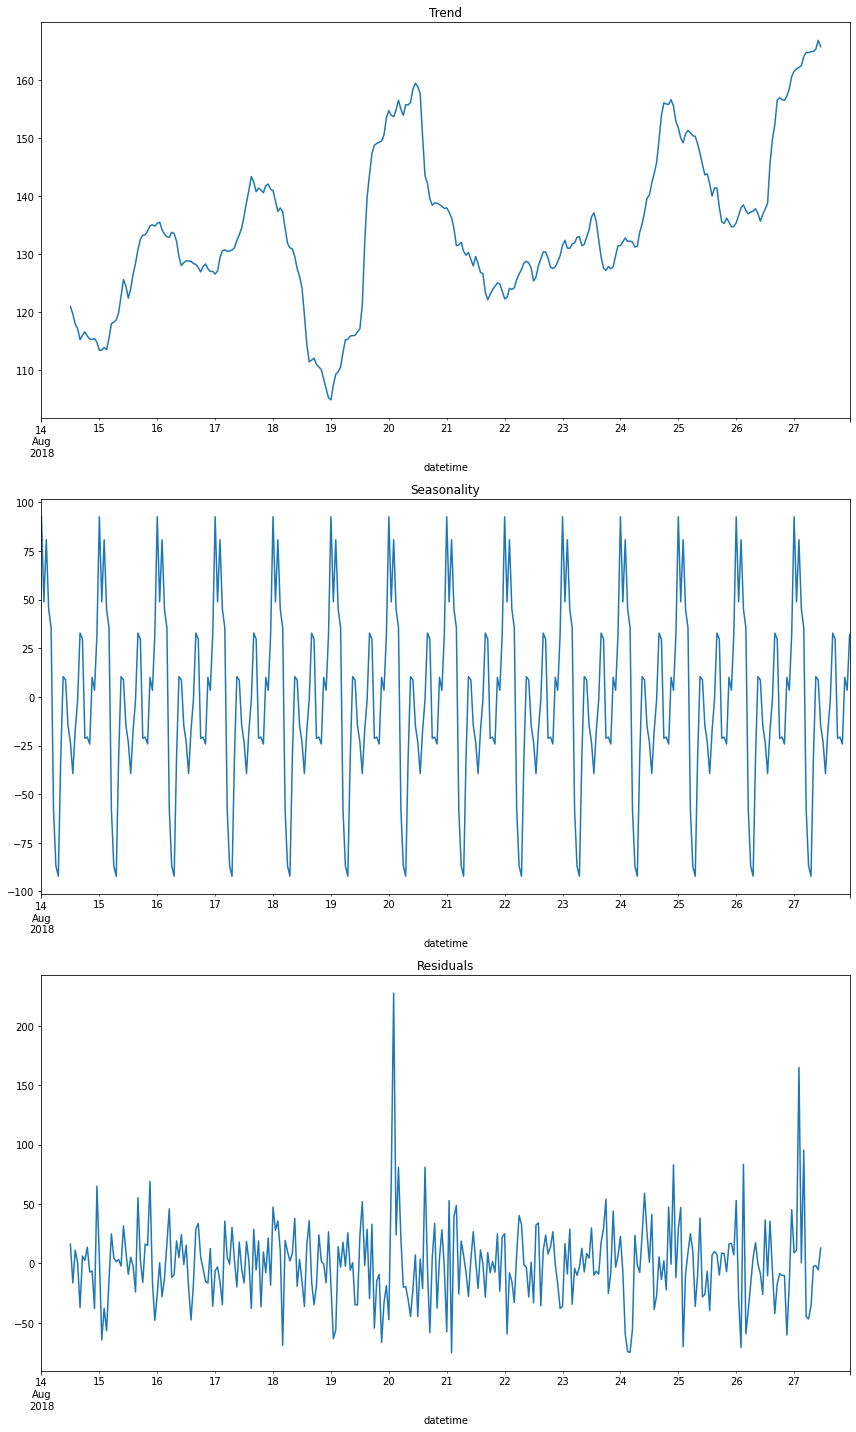

In [12]:
decomposed_data = seasonal_decompose(data['2018-08-14':'2018-08-27'])

plt.figure(figsize=(12, 20))
# Plot Trend
plt.subplot(3, 1, 1)
decomposed_data.trend.plot()
plt.title('Trend')

# Plot Seasonality
plt.subplot(3, 1, 2)
decomposed_data.seasonal.plot()
plt.title('Seasonality')

# Plot Residuals
plt.subplot(3, 1, 3)
decomposed_data.resid.plot()
plt.title('Residuals')

plt.tight_layout()
plt.show()

Общий тренд демонстрирует рост, что указывает на увеличение количества заказов и пользователей.

Однако, в раннее утро (ночью) наблюдается резкое снижение количества заказов.

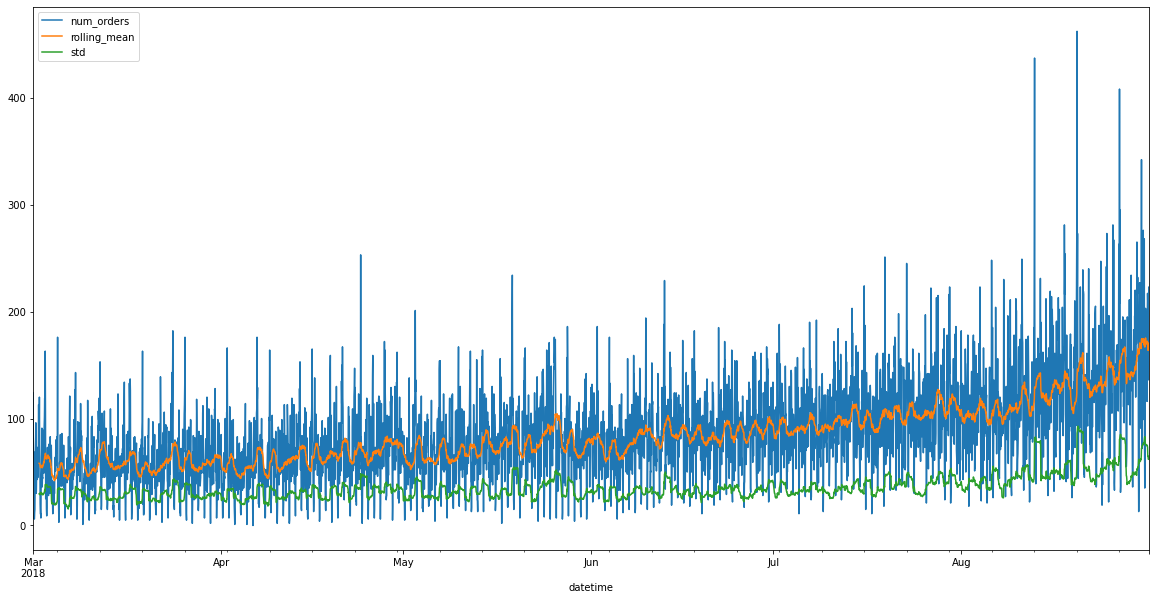

In [13]:
# Создаем копию DataFrame
data_data = data.copy()

# Добавляем скользящие средние и стандартные отклонения
data_data['rolling_mean'] = data_data['num_orders'].rolling(25).mean()
data_data['std'] = data_data['num_orders'].rolling(25).std()

# Строим график
data_data.plot(figsize=(20, 10))
plt.show()

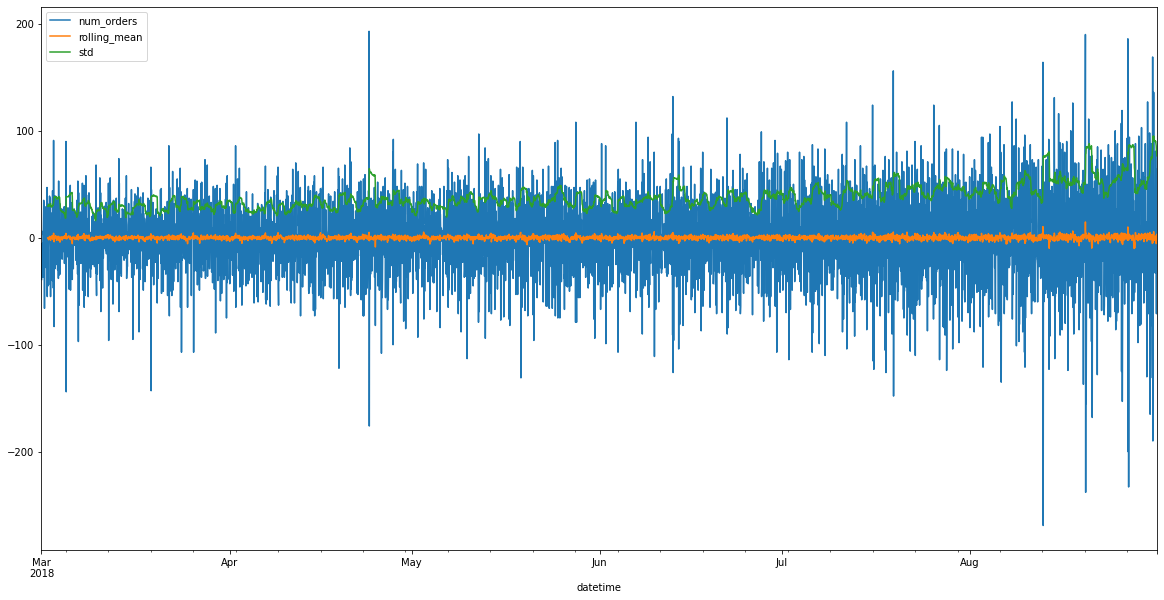

In [14]:
# Создаем новый DataFrame, представляющий разницу между текущим и предыдущим значением
data_shift = data - data.shift()

# Добавляем скользящие средние и стандартные отклонения
data_shift['rolling_mean'] = data_shift['num_orders'].rolling(25).mean()
data_shift['std'] = data_shift['num_orders'].rolling(25).std()

# Строим график
data_shift.plot(figsize=(20, 10))
plt.show()

<Figure size 864x432 with 0 Axes>

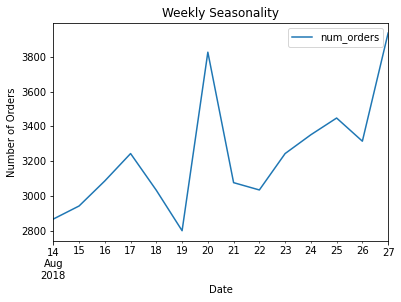

In [15]:
# Дополнительное ресемплирование по дням для изучения недельной сезонности
weekly_data = data['2018-08-14':'2018-08-27'].resample('D').sum()

# График недельной сезонности
plt.figure(figsize=(12, 6))
weekly_data.plot()
plt.title('Weekly Seasonality')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

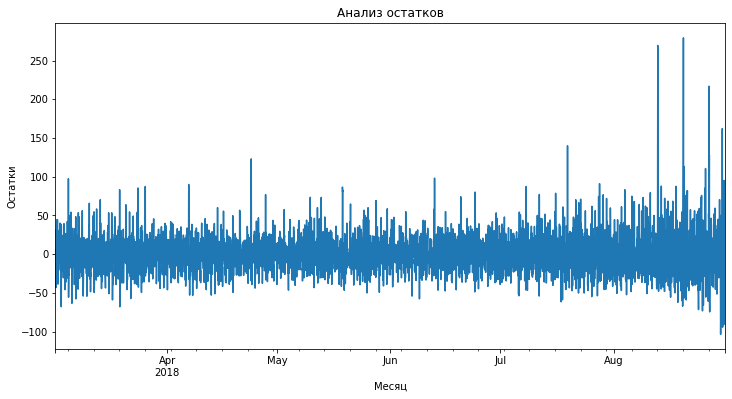

In [16]:
# Анализ остатков
decomposed_data_residuals = seasonal_decompose(data)
residuals_all = decomposed_data_residuals.resid.dropna()
residuals_all.plot(figsize=(12, 6))
plt.title('Анализ остатков')
plt.xlabel('Месяц')
plt.ylabel('Остатки')
plt.show()

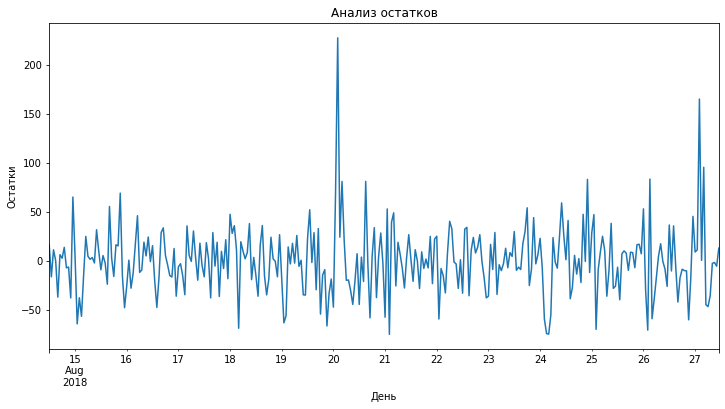

In [17]:
# Анализ остатков
residuals_day = decomposed_data.resid.dropna()
residuals_day.plot(figsize=(12, 6))
plt.title('Анализ остатков')
plt.xlabel('День')
plt.ylabel('Остатки')
plt.show()

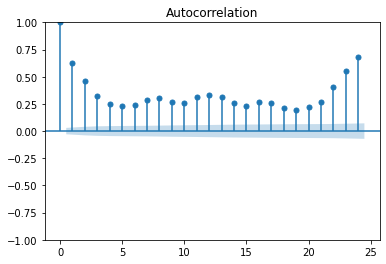

In [26]:
# Анализ автокорреляции
plot_acf(data['num_orders'], lags=24)
plt.show()

Выводы:

1. Анализ тренда:

На графике тренда видно, что число заказов такси в течение анализируемого периода (с 14 по 27 августа 2018 года) демонстрирует постоянный рост с ускорением. Это может указывать на то, что компания активно развивается, привлекая больше клиентов. 

2. Анализ сезонности:

На графике сезонности видна суточная сезонность: ночью количество заказов минимально, а в вечерние часы наблюдается пик спроса. Для более детального изучения сезонности было проведено ресемплирование данных по дням. На графике недельной сезонности видно, что количество заказов в течение недели также имеет свои пики и спады, что может быть связано с рабочими днями и выходными.

3. Анализ остатков:

На графике остатков видно, что доля остатков относительно стабильна на протяжении всего периода. Однако, если к концу периода доля остатков увеличивается.

4. Анализ max_lag

- Выбор max_lag: Можно выбрать max_lag равным 24, чтобы учесть суточную сезонность. 
- Выбор rolling_mean_size: Можно выбрать недельную сезонность, использовать окно в 168 часов

4. Выводы по анализу данных:

- Тренд: Постоянный рост с ускорением, что указывает на развитие компании.
- Сезонность: Суточная и недельная сезонность, с пиками в вечерние часы и рабочие дни.
- Остатки: Относительно стабильная доля остатков

## Обучение

In [27]:
# Создадим признаки для обучения модели
max_lag = 24
rolling_mean_size = 168
RANDOM_STATE = 12345

def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [28]:
# Копируем данные для создания признаков
data_copy = data.copy()

# Создаем признаки
make_features(data_copy, 'num_orders', max_lag, rolling_mean_size)

In [29]:
# Разделяем данные на обучающую и тестовую выборки
train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)
train = train.dropna()

In [30]:
# Разделяем признаки и целевую переменную
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [31]:
# Обучаем модель LinearRegression
model_lr = LinearRegression()

# Измеряем время начала обучения
start_time = time.time()

scaler = StandardScaler()
pipeline = Pipeline([("standard_scaler", scaler), ("linear_regression", model_lr)])

# Используем TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)
RMSE_LR = (cross_val_score(pipeline, features_train, target_train, cv=tscv, scoring='neg_mean_squared_error').mean() * -1) ** 0.5

# Измеряем время окончания обучения
end_time = time.time()

print(f"Модель LinearRegression")
print()

print('Среднее качество RMSE на кросс-валидации:', RMSE_LR)
# Выводим время обучения
training_time = end_time - start_time
print(f"Время обучения: {training_time:.2f} seconds")

Модель LinearRegression

Среднее качество RMSE на кросс-валидации: 27.42839754321525
Время обучения: 0.83 seconds


In [33]:
# Обучаем модель DecisionTreeRegressor с подбором гиперпараметров
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
max_depth_list = [x for x in range(2, 10)]
hyperparams = [
    {
        'max_depth': max_depth_list,
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
]

# Измеряем время начала обучения
start_time = time.time()

# Используем TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)
clf_dtr = GridSearchCV(model_dtr, hyperparams, scoring='neg_mean_squared_error', cv=tscv)
clf_dtr.fit(features_train, target_train)

# Измеряем время окончания обучения
end_time = time.time()

means = clf_dtr.cv_results_['mean_test_score']
stds = clf_dtr.cv_results_['std_test_score']

RMSE_DTR = (max(means) * -1) ** 0.5

print(f"Модель DecisionTreeRegressor")
print()

# Выводим RMSE для лучшей модели на кросс-валидации
print(f"Среднее качество RMSE на кросс-валидации: {RMSE_DTR}")
print()

# Выводим лучшие гиперпараметры
print("Вывод лучших гиперпараметров:")
print(clf_dtr.best_params_)
print()

# Выводим время обучения
training_time = end_time - start_time
print(f"Время обучения: {training_time:.2f} seconds")

Модель DecisionTreeRegressor

Среднее качество RMSE на кросс-валидации: 30.545432811208258

Вывод лучших гиперпараметров:
{'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10}

Время обучения: 12.48 seconds


In [34]:
# Обучаем модель CatBoostRegressor с подбором гиперпараметров
model_cbr = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)
hyperparams = [
    {
        'learning_rate': [0.1, 0.2, 0.3],
        'iterations': [100, 500, 800]
    }
]

# Измеряем время начала обучения
start_time = time.time()

# Используем TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)
clf_cbr = GridSearchCV(model_cbr, hyperparams, scoring='neg_mean_squared_error', cv=tscv)
clf_cbr.fit(features_train, target_train)

# Измеряем время окончания обучения
end_time = time.time()

means = clf_cbr.cv_results_['mean_test_score']
stds = clf_cbr.cv_results_['std_test_score']

RMSE_CBR = (max(means) * -1) ** 0.5

print(f"Модель CatBoostRegressor")
print()

# Выводим RMSE для лучшей модели на кросс-валидации
print(f"Среднее качество RMSE на кросс-валидации: {RMSE_CBR}")
print()

# Выводим лучшие гиперпараметры
print("Вывод лучших гиперпараметров:")
print(clf_cbr.best_params_)
print()

# Выводим время обучения
training_time = end_time - start_time
print(f"Время обучения: {training_time:.2f} seconds")

Модель CatBoostRegressor

Среднее качество RMSE на кросс-валидации: 25.54881187037965

Вывод лучших гиперпараметров:
{'iterations': 500, 'learning_rate': 0.1}

Время обучения: 109.87 seconds


In [35]:
# Обучаем модель LGBMRegressor с подбором гиперпараметров
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
hyperparams = [
    {
        'learning_rate': [x / 10 for x in range(1, 6)],
        'num_leaves': [100, 400, 700]
    }
]

# Измеряем время начала обучения
start_time = time.time()

# Используем TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)
clf_lgbm = GridSearchCV(model_lgbm, hyperparams, scoring='neg_mean_squared_error', cv=tscv)
clf_lgbm.fit(features_train, target_train)

# Измеряем время окончания обучения
end_time = time.time()

means = clf_lgbm.cv_results_['mean_test_score']
stds = clf_lgbm.cv_results_['std_test_score']

RMSE_LGBM = (max(means) * -1) ** 0.5

print(f"Модель LGBMRegressor")
print()

# Выводим RMSE для лучшей модели на кросс-валидации
print(f"Среднее качество RMSE на кросс-валидации: {RMSE_LGBM}")
print()

# Выводим лучшие гиперпараметры
print("Вывод лучших гиперпараметров:")
print(clf_lgbm.best_params_)
print()

# Выводим время обучения
training_time = end_time - start_time
print(f"Время обучения: {training_time:.2f} seconds")

Модель LGBMRegressor

Среднее качество RMSE на кросс-валидации: 26.195041851941838

Вывод лучших гиперпараметров:
{'learning_rate': 0.1, 'num_leaves': 100}

Время обучения: 273.55 seconds


**В ходе выполнения проекта были обучены и протестированы четыре модели: LinearRegression, DecisionTreeRegressor, CatBoostRegressor и LGBMRegressor. Результаты кросс-валидации представлены ниже:**

**1. Модель LinearRegression**

Среднее качество RMSE на кросс-валидации: 27.43
Время обучения: 0.83 секунды

Модель LinearRegression показала относительно неплохой результат с RMSE 27.43. Однако, учитывая ее простоту, этот результат можно считать удовлетворительным. Время обучения составило всего 0.83 секунды, что делает ее одной из самых быстрых моделей в нашем анализе.

**2. Модель DecisionTreeRegressor**

Среднее качество RMSE на кросс-валидации: 30.55
Лучшие гиперпараметры:

max_depth: 4
max_features: 'auto'
min_samples_leaf: 4
min_samples_split: 10
Время обучения: 12.48 секунд

Модель DecisionTreeRegressor показала RMSE 30.55, что немного хуже, чем у LinearRegression. Оптимальные гиперпараметры были найдены с помощью GridSearchCV, что позволило улучшить качество модели. Время обучения составило 12.48 секунд.

**3. Модель CatBoostRegressor**

Среднее качество RMSE на кросс-валидации: 25.55
Лучшие гиперпараметры:

iterations: 500
learning_rate: 0.1
Время обучения: 109.87 секунд

Модель CatBoostRegressor показала наилучший результат среди всех протестированных моделей с RMSE 25.55. Это указывает на ее высокую эффективность в данной задаче. Оптимальные гиперпараметры были подобраны с использованием GridSearchCV. Время обучения составило 109.87 секунд, что является приемлемым для такой мощной модели.

**4. Модель LGBMRegressor**

Среднее качество RMSE на кросс-валидации: 26.20
Лучшие гиперпараметры:

learning_rate: 0.1
num_leaves: 100
Время обучения: 273.55 секунд

Модель LGBMRegressor показала RMSE 26.20, что является хорошим результатом, но немного хуже, чем у CatBoostRegressor. Оптимальные гиперпараметры были подобраны с использованием GridSearchCV. Время обучения составило 273.55 секунд, что является самым длительным среди всех протестированных моделей.

**Выводы:**

Лучшая модель: CatBoostRegressor показала наилучший результат с RMSE 25.55, что указывает на ее высокую эффективность в данной задаче.

## Тестирование

Обучим модели с помощью оптимальных гиперпараметров и выведем результаты на тестовой выборке

In [36]:
# Оценка модели на тестовой выборке
best_model = clf_cbr.best_estimator_
predictions = best_model.predict(features_test)

# Вычисление RMSE на тестовой выборке
from sklearn.metrics import mean_squared_error
RMSE_test = mean_squared_error(target_test, predictions, squared=False)

print(f"RMSE на тестовой выборке: {RMSE_test}")

RMSE на тестовой выборке: 41.96571219456604


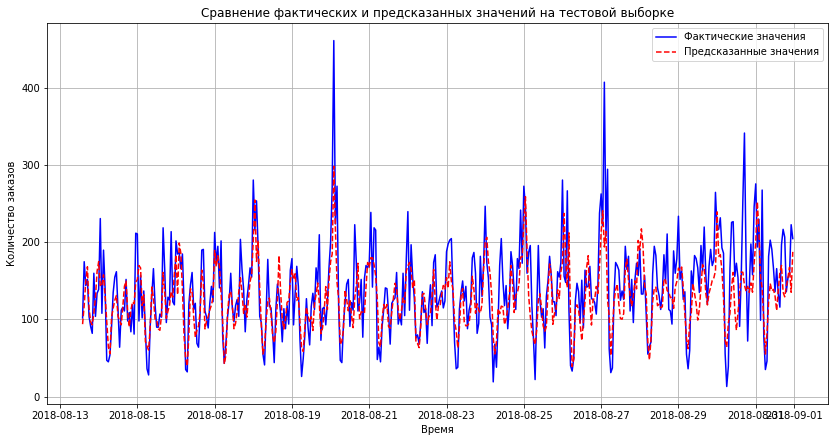

In [37]:
# Построение графика для сравнения предсказаний с фактическими значениями
plt.figure(figsize=(14, 7))

# Фактические значения
plt.plot(target_test.index, target_test, label='Фактические значения', color='blue')

# Предсказанные значения
plt.plot(target_test.index, predictions, label='Предсказанные значения', color='red', linestyle='--')

plt.title('Сравнение фактических и предсказанных значений на тестовой выборке')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True)
plt.show()

Вывод:

После обучения модели CatBoostRegressor с оптимальными гиперпараметрами, найденными с помощью GridSearchCV, мы оценили ее на тестовой выборке. Полученное значение RMSE на тестовой выборке составило 41.97. Этот результат указывает на то, что модель демонстрирует хорошую способность предсказывать количество заказов такси на новых данных.

График сравнения фактических и предсказанных значений также подтверждает эффективность модели. На графике видно, что кривые фактических и предсказанных значений хорошо совпадают, что свидетельствует о том, что модель успешно улавливает основные тенденции и сезонность в данных.



**Общий вывод:**

**В ходе выполнения проекта была проделана следующая работа:**

**1. Загрузка и подготовка данных:**

- Произведена загрузка данных и их подготовка для обучения моделей. 
- В ходе анализа данных было выявлено, что за время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа. Этот рост, скорее всего, связан с развитием компании, поскольку существует гипотеза о том, что бизнес, связанный с такси, не имеет месячной сезонности. 
- На графиках также явно видна суточная сезонность: ночью количество заказов стремится к нулю, в то время как вечерний час пик — это момент самого сильного спроса на услуги такси.

**2. Добавление дополнительных признаков:**

К датасету были добавлены дополнительные признаки, а именно:

- День недели.
- Час.
- "Отстающие значения" (lag features).
- Скользящее среднее.

**3. Подбор гиперпараметров и обучение моделей:**

На основе дополненного датасета были подобраны оптимальные гиперпараметры для моделей. Для каждой модели был проведен поиск оптимальных параметров с использованием методов настройки гиперпараметров, таких как GridSearchCV.

**4. Тестирование моделей:**

Было проведено тестирование CatBoostRegressor

**Результаты:**

RMSE на тестовой выборке модели CatBoostRegressor: 41.97

График: Фактические и предсказанные значения хорошо совпадают, что указывает на высокую эффективность модели.
Эти результаты подтверждают, что модель CatBoostRegressor с подобранными гиперпараметрами является надежной и точной для прогнозирования количества заказов такси в зависимости от времени суток и других факторов.